Demonstration of MouseGAN based Symbolic Music Generation

Inspired by: https://github.com/salu133445/musegan/tree/main

In [133]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pretty_midi
from pathlib import Path
from typing import Optional, Dict, Any, Tuple

# Disable CUDA warnings
os.environ['TORCH_CPP_LOG_LEVEL'] = 'WARN'

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)


# Define hyperparameters (must match your trained model)
latent_dim = 128
n_tracks = 5
n_measures = 4
measure_resolution = 16
n_pitches = 72
lowest_pitch = 24

# Add these two lines here:
programs = [0, 0, 25, 33, 48]
is_drums  = [True, False, False, False, False]

MouseGAN Generator

In [134]:
class GeneraterBlock(nn.Module):
    """Generator block with transposed convolution, batch norm, and ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.transconv = nn.ConvTranspose3d(
            in_channels, out_channels, kernel_size, stride, padding, bias=True
        )
        self.batchnorm = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.batchnorm(self.transconv(x)))

In [135]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneraterBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneraterBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneraterBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneraterBlock(64, 32, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneraterBlock(32, 16, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneraterBlock(16, 1, (1, 1, 12), (1, 1, 12))
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

In [136]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneraterBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneraterBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneraterBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneraterBlock(64, 32, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneraterBlock(32, 16, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneraterBlock(16, 1, (1, 1, 12), (1, 1, 12))
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

In [ ]:
class MuseGANGeneratorTorch:
    def __init__(self, model_path: str, device: Optional[str] = None, verbose: bool = True):
        self.model_path = model_path
        self.verbose = verbose

        # MuseGAN hyperparameters
        self.n_tracks = n_tracks
        self.n_bars = n_measures
        self.n_steps_per_bar = measure_resolution
        self.n_pitches = n_pitches
        self.lowest_pitch = lowest_pitch
        self.track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']

        # PyTorch device, for the case when CUDA is available
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model: Optional[torch.nn.Module] = None

        if self.verbose:
            print(f"MuseGANGeneratorTorch initialized on {self.device}")

    def load_model(self) -> bool:
        if not os.path.isfile(self.model_path):
            if self.verbose:
                print(f"Model file not found: {self.model_path}")
            return False
        try:
            # Create the Generator instance
            self.model = Generator()
            
            # Load the state dictionary
            state_dict = torch.load(self.model_path, map_location=self.device)
            
            # Handle different state_dict formats
            if 'state_dict' in state_dict:
                # If the checkpoint contains additional info
                self.model.load_state_dict(state_dict['state_dict'])
            elif 'model_state_dict' in state_dict:
                # Another common format
                self.model.load_state_dict(state_dict['model_state_dict'])
            else:
                # Assume the file is just the state_dict
                self.model.load_state_dict(state_dict)
            
            self.model.to(self.device)
            self.model.eval()
            
            if self.verbose:
                print(f"Loaded PyTorch weights from {self.model_path}")
            return True
        except Exception as e:
            if self.verbose:
                print(f"Failed to load model: {e}")
            return False

    def generate_music(self, n_samples: int = 4, temperature: float = 1.0) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("Model is not loaded. Please call load_model first.")

        noise = torch.randn(n_samples, latent_dim, device=self.device) * temperature
        
        with torch.no_grad():
            logits = self.model(noise)
        
        logits = logits.cpu().numpy()

        if self.verbose:
            print(f"🎵 Generated music logits: {logits.shape}")
        return logits

    def postprocess_music(self, logits: np.ndarray, threshold: float = 0.0) -> np.ndarray:
        piano_roll = (logits > threshold).astype(np.float32)
        piano_roll[..., :self.lowest_pitch] = 0
        return piano_roll

    def music_to_pianoroll(self, music: np.ndarray, track_idx: int = 1) -> np.ndarray:
        """Convert music tensor to piano roll for a specific track."""
        # takes the first sample if we have a batch
        if music.ndim == 4:
            # music shape: (n_samples, n_tracks, n_steps, n_pitches)
            sample_music = music[0]
        elif music.ndim == 3:
            # music shape: (n_tracks, n_steps, n_pitches)
            sample_music = music
        else:
            raise ValueError(f"Unexpected music shape: {music.shape}")

        # extract the 2D (n_steps, n_pitches) roll for the given track
        track_roll = sample_music[track_idx] 
        return track_roll

    def plot_pianoroll(self, music: np.ndarray, sample_idx: int = 0, track_idx: int = 1):
        """Plot a single track’s piano roll for one sample."""
        #  takes the first sample if we have a batch
        if music.ndim == 4:
            # music shape: (n_samples, n_tracks, n_steps, n_pitches)
            sample_music = music[sample_idx]
        elif music.ndim == 3:
            # music shape: (n_tracks, n_steps, n_pitches)
            sample_music = music
        else:
            raise ValueError(f"Unexpected music shape: {music.shape}")

        # resampled sample_music
        track_roll = sample_music[track_idx]  

        # plotting
        plt.figure(figsize=(12, 4))
        plt.imshow(track_roll.T, aspect='auto', origin='lower', cmap='Blues')
        plt.title(f"{self.track_names[track_idx]} Track - Sample {sample_idx}")
        plt.xlabel('Time step')
        plt.ylabel('Pitch')
        plt.colorbar(label='Velocity')
        plt.show()
        

    def plot_track_comparison(self, music: np.ndarray, sample_idx: int = 0):
        """Plot all tracks side by side for one sample."""
        # takes the first sample if we have a batch
        if music.ndim == 4:
            # (n_samples, n_tracks, n_steps, n_pitches)
            sample_music = music[sample_idx]
        elif music.ndim == 3:
            # (n_tracks, n_steps, n_pitches)
            sample_music = music
        else:
            raise ValueError(f"Unexpected music shape: {music.shape}")

        # 2) resampled sample_music
        fig, axes = plt.subplots(1, self.n_tracks, figsize=(20, 4))
        
        for track_idx in range(self.n_tracks):
            # extract the 2D array for this track
            track_roll = sample_music[track_idx]  
            
            # transpose to (n_pitches, n_steps)
            im = axes[track_idx].imshow(
                track_roll.T, 
                aspect='auto', 
                origin='lower', 
                cmap='Blues', 
                interpolation='nearest'
            )
            axes[track_idx].set_title(self.track_names[track_idx])
            axes[track_idx].set_xlabel('Time Steps')
            if track_idx == 0:
                axes[track_idx].set_ylabel('MIDI Pitch')
        
        plt.tight_layout()
        plt.show()

    def analyze_music_statistics(self, music: np.ndarray) -> Dict[str, Dict[str, Any]]:
        """Analyze statistics for each track."""
        # if we got a batch, grab the first sample
        if music.ndim == 4:
            # music shape: (n_samples, n_tracks, n_steps, n_pitches)
            sample_music = music[0]
        elif music.ndim == 3:
            # music shape: (n_tracks, n_steps, n_pitches)
            sample_music = music
        else:
            raise ValueError(f"Unexpected music shape: {music.shape}")

        stats = {}
        for track_idx, track_name in enumerate(self.track_names):
            track_data = sample_music[track_idx]  # shape (n_steps, n_pitches)

            active_notes = int((track_data > 0).sum())
            total_notes = track_data.size
            density = (active_notes / total_notes) * 100

            active_pitches = np.where(track_data.sum(axis=0) > 0)[0]
            if active_pitches.size > 0:
                pitch_range = (active_pitches[0] + self.lowest_pitch,
                            active_pitches[-1] + self.lowest_pitch)
                unique_pitches = int(active_pitches.size)
            else:
                pitch_range = (0, 0)
                unique_pitches = 0

            stats[track_name] = {
                'active_notes': active_notes,
                'density': density,
                'pitch_range': pitch_range,
                'unique_pitches': unique_pitches
            }

        return stats
    

    def save_as_numpy(self, music: np.ndarray, filename: str):
        """Save music as numpy array."""
        np.save(filename, music)
        if self.verbose:
            print(f"Numpy array saved: {filename}")

    def save_as_midi(self, music: np.ndarray, filename: str = "generated.mid", tempo: int = 120):
        midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
        step_time = 60 / tempo / (self.n_steps_per_bar / 4)

        # choose the first sample if you have multiple
        sample_music = music[0] if music.ndim == 4 else music

        for track_idx in range(self.n_tracks):
            instr = pretty_midi.Instrument(
                program = programs[track_idx],
                is_drum = is_drums[track_idx],
                name    = self.track_names[track_idx]
            )
            track_roll = sample_music[track_idx, :, :]
            for step, pitches in enumerate(track_roll):
                for pitch, vel in enumerate(pitches):
                    if vel > 0:
                        start = step * step_time
                        end   = start + step_time
                        instr.notes.append(
                            pretty_midi.Note(
                                velocity=int(vel * 127),
                                pitch   = pitch + self.lowest_pitch,
                                start   = start,
                                end     = end
                            )
                        )
            midi.instruments.append(instr)

        midi.write(filename)
        if self.verbose:
            print(f"MIDI saved: {filename}")

In [ ]:
# Configuration
MODEL_PATH = "generator_final.pth"  
OUTPUT_DIR = "generated_music"
N_SAMPLES = 4

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set seed for reproducibility
set_seed(42)

# Initialize generator
print("Initializing MuseGAN Generator...")
generator = MuseGANGeneratorTorch(MODEL_PATH, verbose=True)

# Load model
model_loaded = generator.load_model()
if not model_loaded:
    print("Model loading failed, aborting.")
    exit(1)

print("Model loaded successfully!")

Initializing MuseGAN Generator...
✅ MuseGANGeneratorTorch initialized on cpu
✅ Loaded PyTorch weights from generator_final.pth
✅ Model loaded successfully!


In [139]:
# Generate music
print(f"Generating {N_SAMPLES} music samples...")
logits = generator.generate_music(n_samples=N_SAMPLES, temperature=1.0)
processed_music = generator.postprocess_music(logits, threshold=0.5)

print("Analyzing generated music...")

# Get statistics
stats = generator.analyze_music_statistics(processed_music)

Generating 4 music samples...
🎵 Generated music logits: (4, 5, 64, 72)
Analyzing generated music...


In [ ]:
# Display statistics in a nice format
print("\n" + "="*60)
print("GENERATED MUSIC STATISTICS")
print("="*60)

for track_name, track_stats in stats.items():
    print(f"\n {track_name.upper()}:")
    print(f"   Active Notes: {track_stats['active_notes']:,}")
    print(f"   Density: {track_stats['density']:.1f}%")
    print(f"   Pitch Range: {track_stats['pitch_range'][0]} - {track_stats['pitch_range'][1]}")
    print(f"   Unique Pitches: {track_stats['unique_pitches']}")

print("\nCreating visualizations...")


GENERATED MUSIC STATISTICS

📊 DRUMS:
   Active Notes: 16
   Density: 0.3%
   Pitch Range: 54 - 54
   Unique Pitches: 1

📊 PIANO:
   Active Notes: 57
   Density: 1.2%
   Pitch Range: 61 - 64
   Unique Pitches: 3

📊 GUITAR:
   Active Notes: 108
   Density: 2.3%
   Pitch Range: 54 - 82
   Unique Pitches: 6

📊 BASS:
   Active Notes: 0
   Density: 0.0%
   Pitch Range: 0 - 0
   Unique Pitches: 0

📊 STRINGS:
   Active Notes: 220
   Density: 4.8%
   Pitch Range: 54 - 91
   Unique Pitches: 11

🎨 Creating visualizations...



🎹 Piano Roll Visualization (Piano Track):


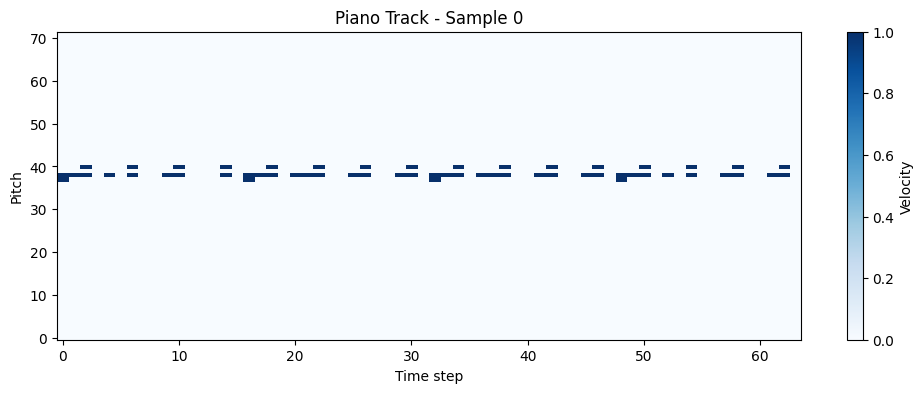

🎵 All Tracks Comparison:


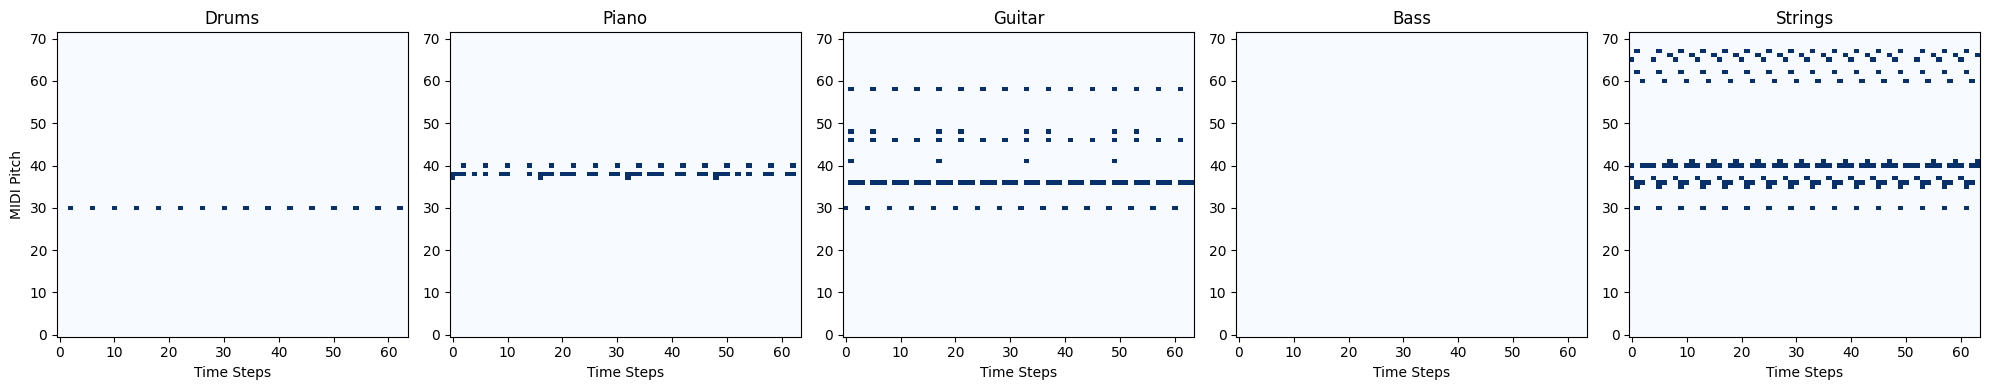

💾 Saving generated music...


In [ ]:
# Plot individual track (Piano by default)
print("\n Piano Roll Visualization (Piano Track):")
generator.plot_pianoroll(processed_music, sample_idx=0, track_idx=1)

print(" All Tracks Comparison:")
generator.plot_track_comparison(processed_music, sample_idx=0)

print(" Saving generated music...")

In [ ]:
# Save each sample
for i in range(N_SAMPLES):
    if len(processed_music.shape) == 4:
        sample_music = processed_music
    else:
        sample_music = processed_music[i:i+1]
    
    # Save as numpy
    numpy_path = os.path.join(OUTPUT_DIR, f'generated_music_sample_{i}.npy')
    generator.save_as_numpy(sample_music, numpy_path)
    
    # Save as MIDI
    midi_path = os.path.join(OUTPUT_DIR, f'generated_music_sample_{i}.mid')
    generator.save_as_midi(sample_music, midi_path)

print(f"\n All files saved to: {OUTPUT_DIR}")

def generate_and_visualize(n_samples=2, temperature=1.0, threshold=0.5, track_to_plot=1):
    """Interactive function to generate and visualize music with custom parameters."""
    print(f" Generating {n_samples} samples with temperature={temperature}, threshold={threshold}")
    
    # Generate music
    music = generator.generate_music(n_samples=n_samples, temperature=temperature)
    processed = generator.postprocess_music(music, threshold=threshold)
    
    # Visualize
    generator.plot_pianoroll(processed, sample_idx=0, track_idx=track_to_plot)
    
    # Show stats
    stats = generator.analyze_music_statistics(processed)
    track_name = generator.track_names[track_to_plot]
    track_stats = stats[track_name]
    
    print(f"\n {track_name} Statistics:")
    print(f"   Density: {track_stats['density']:.1f}%")
    print(f"   Active Notes: {track_stats['active_notes']:,}")
    print(f"   Pitch Range: {track_stats['pitch_range'][0]} - {track_stats['pitch_range'][1]}")
    
    return processed

💾 Numpy array saved: generated_music\generated_music_sample_0.npy
💾 MIDI saved: generated_music\generated_music_sample_0.mid
💾 Numpy array saved: generated_music\generated_music_sample_1.npy
💾 MIDI saved: generated_music\generated_music_sample_1.mid
💾 Numpy array saved: generated_music\generated_music_sample_2.npy
💾 MIDI saved: generated_music\generated_music_sample_2.mid
💾 Numpy array saved: generated_music\generated_music_sample_3.npy
💾 MIDI saved: generated_music\generated_music_sample_3.mid

✅ All files saved to: generated_music



🎮 Interactive Generation Example:
🎵 Generating 2 samples with temperature=1.2, threshold=0.4
🎵 Generated music logits: (2, 5, 64, 72)


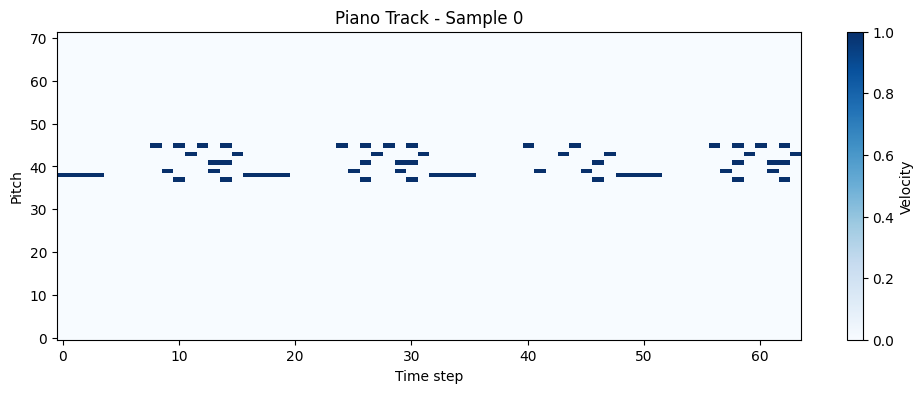


📊 Piano Statistics:
   Density: 1.3%
   Active Notes: 62
   Pitch Range: 61 - 69

🔄 Batch Generation with Different Parameters:


In [ ]:
# Example usage - modify these parameters to experiment
print("\n Interactive Generation Example:")
interactive_music = generate_and_visualize(
    n_samples=2, 
    temperature=1.2,  # Try different values: 0.5, 1.0, 1.5, 2.0
    threshold=0.4,    # Try different values: 0.3, 0.5, 0.7
    track_to_plot=1   # 0=Drums, 1=Piano, 2=Guitar, 3=Bass, 4=Strings
)

print("\n Batch Generation with Different Parameters:")

In [144]:
# Generate multiple versions with different temperatures
temperatures = [0.5, 1.0, 1.5, 2.0]
batch_results = {}

for temp in temperatures:
    print(f"\nGenerating with temperature {temp}...")
    music = generator.generate_music(n_samples=1, temperature=temp)
    processed = generator.postprocess_music(music, threshold=0.5)
    batch_results[temp] = processed



Generating with temperature 0.5...
🎵 Generated music logits: (1, 5, 64, 72)

Generating with temperature 1.0...
🎵 Generated music logits: (1, 5, 64, 72)

Generating with temperature 1.5...
🎵 Generated music logits: (1, 5, 64, 72)

Generating with temperature 2.0...
🎵 Generated music logits: (1, 5, 64, 72)


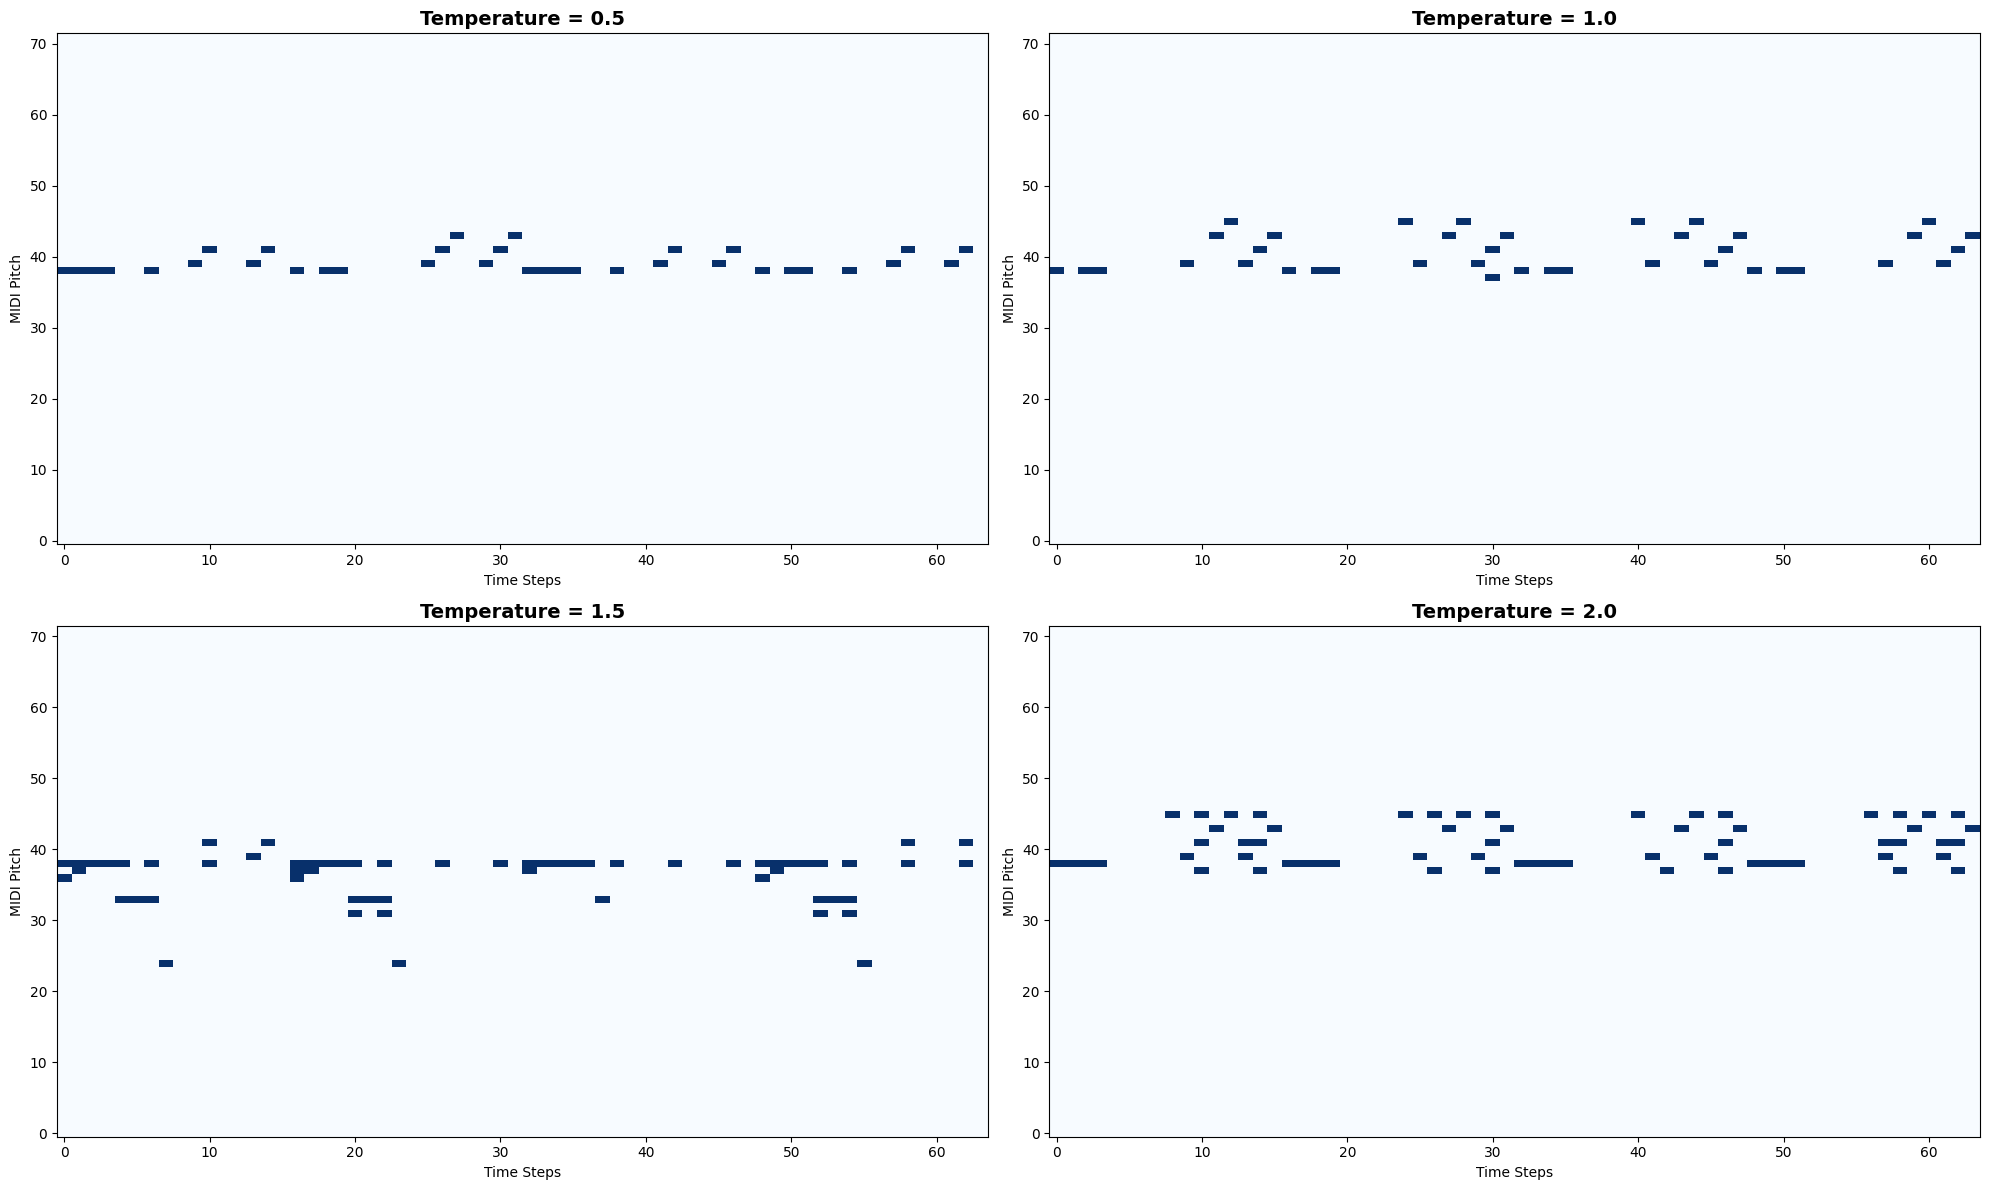


🎉 Script execution complete!

📋 Summary:
   - Generated 4 music samples
   - Saved files to: generated_music
   - Model loaded: ✅ Successfully
   - Visualizations created: ✅ Yes

💡 You can now:
   - Modify parameters for interactive generation
   - Experiment with different temperatures and thresholds
   - Visualize different tracks and samples
   - Load and play the generated MIDI files


In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, temp in enumerate(temperatures):
    pianoroll = generator.music_to_pianoroll(batch_results[temp], track_idx=1)
    
    im = axes[i].imshow(pianoroll.T, aspect='auto', origin='lower', 
                       cmap='Blues', interpolation='nearest')
    axes[i].set_title(f'Temperature = {temp}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel('MIDI Pitch')

plt.tight_layout()
plt.show()

print("\n Script execution complete!")
print("\n Summary:")
print(f"   - Generated {N_SAMPLES} music samples")
print(f"   - Saved files to: {OUTPUT_DIR}")
print(f"   - Model loaded: {' Successfully' if model_loaded else ' Failed'}")
print(f"   - Visualizations created:  Yes")
print("\n You can now:")
print("   - Modify parameters for interactive generation")
print("   - Experiment with different temperatures and thresholds")
print("   - Visualize different tracks and samples")
print("   - Load and play the generated MIDI files")